<div class='alert alert-success'>
    <h1 align="center"> Farsi digit dataset Using GAN Model</h1> 
     <h2 align="center">   One Process like an Image classification </h2>
</div>

In [1]:
# Import Required Library
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models, optimizers
from skimage.transform import resize
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as io

In [3]:
# Load dataset
dataset = io.loadmat('./Data_hoda_full.mat')

In [7]:
# Test and training set split
X_train_original = np.squeeze(dataset['Data'][:10000])
y_train = np.squeeze(dataset['labels'][:10000])
X_test_original = np.squeeze(dataset['Data'][10000:12000])
y_test = np.squeeze(dataset['labels'][10000:12000])

In [5]:
# Resize images to (5, 5)
X_train_5by5 = [resize(img, (5, 5)) for img in X_train_original]
X_test_5by5 = [resize(img, (5, 5)) for img in X_test_original]

# Reshape
X_train = np.array([x.reshape(25) for x in X_train_5by5])
X_test = np.array([x.reshape(25) for x in X_test_5by5])

# Normalize images to the range [-1, 1]
X_train = (X_train.astype(np.float32) - 0.5) / 0.5
X_test = (X_test.astype(np.float32) - 0.5) / 0.5

# One-hot encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

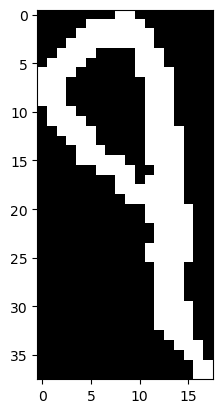

Label of 9000th image is: 9


In [11]:
i=9000
image = X_train_original[i]
label = y_train[i]
plt.imshow(image, cmap='gray')
plt.show()
print("Label of {}th image is: {}".format(i, label))

In [12]:
image.shape

(38, 18)

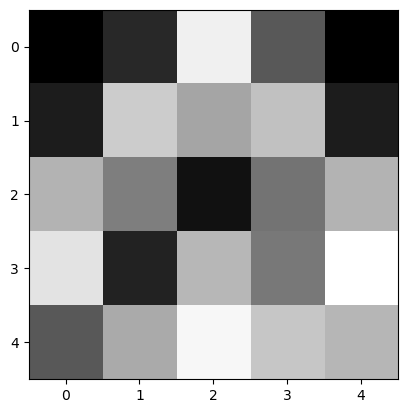

In [13]:
image = X_train_5by5[1]
plt.imshow(image, cmap='gray')
plt.show()

In [14]:
X_train[0].shape

(25,)

In [18]:
# GAN implementation
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=latent_dim, activation='relu'))
    model.add(layers.Dense(25, activation='tanh'))
    return model

def build_discriminator(img_shape):
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=img_shape, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [19]:
## GAN parameters
latent_dim = 100
img_shape = 25
optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build and compile the generator
generator = build_generator(latent_dim)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# Build and compile the GAN
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)



In [22]:
# Training the GAN
epochs = 2000
batch_size = 64

# Extract trainable variables for the optimizer
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

# Build and compile the generator
generator = build_generator(latent_dim)
generator.compile(loss='binary_crossentropy', optimizer=generator_optimizer)

# Build and compile the GAN
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer)

In [24]:

import imageio
import os
# Training loop
# Create a folder to save the generated images
if not os.path.exists('generated_images'):
    os.makedirs('generated_images')
for epoch in range(epochs):
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    generated_images = generator.predict(noise)
    real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]

    labels_real = np.ones((batch_size, 1))
    labels_fake = np.zeros((batch_size, 1))

    with tf.GradientTape() as tape:
        d_loss_real = discriminator(real_images)
        d_loss_real = tf.keras.losses.binary_crossentropy(tf.ones_like(d_loss_real), d_loss_real)
        d_loss_fake = discriminator(generated_images)
        d_loss_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(d_loss_fake), d_loss_fake)
        d_loss = 0.5 * tf.reduce_mean(d_loss_real + d_loss_fake)

    grads_discriminator = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grads_discriminator, discriminator.trainable_variables))

    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    labels_gan = np.ones((batch_size, 1))

    with tf.GradientTape() as tape:
        g_loss = gan(noise)
        g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(g_loss), g_loss)
        g_loss = tf.reduce_mean(g_loss)

    grads_generator = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads_generator, generator.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.numpy()}, G Loss: {g_loss.numpy()}")
        # Save generated images at specified intervals
        if epoch % 500 == 0:
            generated_images = generator.predict(np.random.normal(0, 1, size=(16, latent_dim)))
            generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]

            fig, axs = plt.subplots(4, 4, figsize=(4, 4))
            cnt = 0
            for i in range(4):
                for j in range(4):
                    axs[i, j].imshow(generated_images[cnt].reshape(5, 5), cmap='gray')
                    axs[i, j].axis('off')
                    cnt += 1

            plt.savefig(f'generated_images/epoch_{epoch}.png')
            plt.close()

# Create GIF from saved images
images = []
for epoch in range(0, epochs, 200):
    filename = f'generated_images/epoch_{epoch}.png'
    images.append(imageio.imread(filename))

imageio.mimsave('generated_images/generation_animation.gif', images, duration=0.5)


1/1 [==============================] - 0s 161ms/step
Epoch 0, D Loss: 0.6428020596504211, G Loss: 0.753429651260376
1/1 [==============================] - 0s 50ms/step
Epoch 100, D Loss: 0.9308212995529175, G Loss: 0.35714852809906006
1/1 [==============================] - 0s 63ms/step
Epoch 200, D Loss: 1.1086832284927368, G Loss: 0.22821834683418274
1/1 [==============================] - 0s 51ms/step
Epoch 300, D Loss: 1.17586088180542, G Loss: 0.190790593624115
1/1 [==============================] - 0s 66ms/step
Epoch 400, D Loss: 1.2172359228134155, G Loss: 0.1781664490699768
1/1 [==============================] - 0s 50ms/step
Epoch 500, D Loss: 1.2249611616134644, G Loss: 0.16821464896202087
1/1 [==============================] - 0s 50ms/step
Epoch 600, D Loss: 1.2483532428741455, G Loss: 0.1651259958744049
1/1 [==============================] - 0s 50ms/step
Epoch 700, D Loss: 1.263536810874939, G Loss: 0.1594640612602234
1/1 [==============================] - 0s 45ms/step
Epoch 8

In [ ]:
## To Be Continued

